In [1]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle as pkl
import sys
import requests
import os
import math
from pprint import pprint
from Bio.PDB import PDBParser
import concurrent.futures
from collections import defaultdict
from folding.utils.ops import check_and_download_pdbs, check_if_directory_exists

In [2]:
COMPLETE_IDs_FILE = "./pdb_ids_complete.pkl"
INCOMPLETE_IDs_FILE = "./pdb_ids_incomplete.pkl"
NOT_DOWNLOADABLE_IDs_FILE = "./pdb_ids_not_downloadable.pkl"

COMPLETE_PDB_FILES = "./complete_pdbs/"
INCOMPLETE_PDB_FILES = "./incomplete_pdbs/"


def analyze_pdb_batch(pdb_ids: dict, delete_pdb: bool = False):
    # Creating empty pandas dataframe
    data_dict = defaultdict()

    def analyze_pdb(
        pdb_id: str,
    ):
        nonlocal data_dict, delete_pdb
        # Downloading the PDB file
        download_pdb(pdb_directory=COMPLETE_PDB_FILES, pdb_id=pdb_id + ".pdb")
        parser = PDBParser()

        structure = parser.get_structure(pdb_id, f"{COMPLETE_PDB_FILES}{pdb_id}.pdb")

        # Get all atoms
        atoms = [atom for atom in structure.get_atoms()]

        # The number of atoms in the molecule
        num_atoms = len(atoms)

        if delete_pdb:
            # Deleting the pdb file
            os.remove(f"{COMPLETE_PDB_FILES}{pdb_id}.pdb")

        data_dict[pdb_id] = num_atoms

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(analyze_pdb, pdb_id)
            for k, v in pdb_ids.items()
            for pdb_id in v
        ]
        concurrent.futures.wait(futures)

    # Creating dataframe from data_dict
    df = pd.DataFrame.from_dict(data_dict, orient="index", columns=["Number of Atoms"])

    return df


def download_pdb(pdb_directory: str, pdb_id: str) -> bool:

    url = f"https://files.rcsb.org/download/{pdb_id}"
    path = os.path.join(pdb_directory, f"{pdb_id}")

    r = requests.get(url)
    if r.status_code == 200:

        check_if_directory_exists(output_directory=pdb_directory)
        with open(path, "w") as file:
            file.write(r.text)

        return True
    else:
        return False

In [3]:
with open(COMPLETE_IDs_FILE, "rb") as f:
    complete_pdb_ids = pkl.load(f)

mini_batch = {k: complete_pdb_ids[k] for k in list(complete_pdb_ids)[:2]}

In [4]:
import warnings

warnings.filterwarnings("ignore")
df = analyze_pdb_batch(complete_pdb_ids, delete_pdb=False)
df.to_csv("complete_pdbs_analysis.csv")

array([[<Axes: title={'center': 'Number of Atoms'}>]], dtype=object)

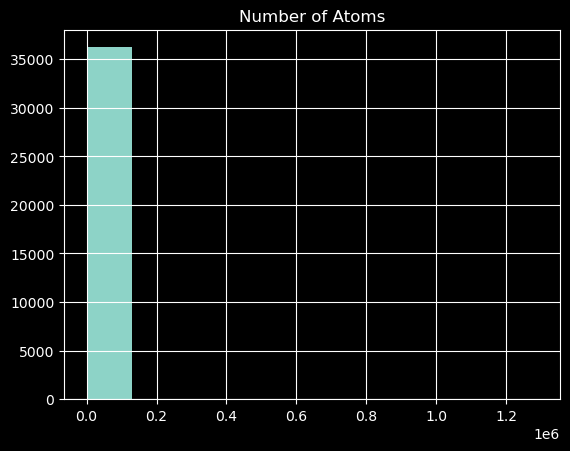

In [5]:
df.hist()